###### <span style="color: gray ">ライブラリをまとめてインポート</span>

In [1]:
# Pandas: データ分析を容易にするためのライブラリ
import pandas as pd

# NumPy: 数値計算を効率的に行うためのライブラリ
import numpy as np

# Matplotlib: グラフ描画のためのライブラリ
import matplotlib.pyplot as plt

# SciPy: 科学技術計算のためのライブラリ
from scipy.stats import norm  # 正規分布に関連する関数を扱うモジュール

# Scikit-learn: 機械学習のためのライブラリ
from sklearn.linear_model import LinearRegression  # 線形回帰モデルを扱うモジュール

# <span style="color:RoyalBlue; ">6.2 古典的最小二乗（CLS）法</span>

## <span style="color: DeepPink; ">6.2.4 CLS法の実装</span>

###### <span style="color: gray ">コード6.1　3つの吸収をもつスペクトルを作成</span>

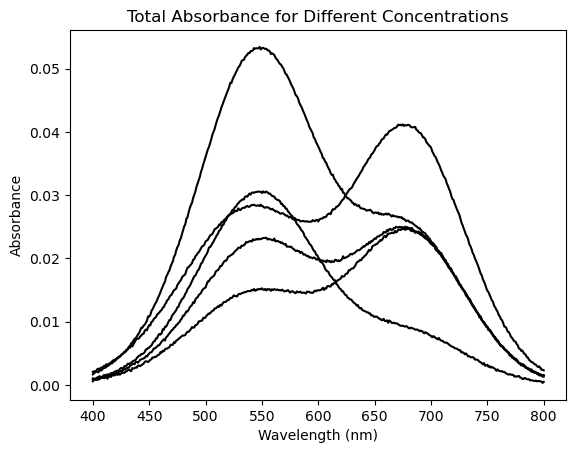

In [2]:
# 波長範囲の設定
wave = np.arange(400, 801, 1)
# アントシアニン1、アントシアニン2、クロロフィルの正規分布に基づく吸収スペクトルの定義
antho1 = norm.pdf(wave, 530, 60)  # 中心530nm, 標準偏差60nm
antho2 = norm.pdf(wave, 550, 50)  # 中心550nm, 標準偏差50nm
chlo = norm.pdf(wave, 680, 50)    # 中心680nm, 標準偏差50nm
# 濃度の配列
concen = np.array([[1, 2, 3],
                   [1, 3, 1],
                   [1, 1, 3],
                   [3, 1, 5],
                   [2, 5, 3]])
# 各濃度に基づく合計吸収スペクトルの計算
data = []
for c in concen:
    total_abs = c[0] * antho1 + c[1] * antho2 + c[2] * chlo
    total_abs = total_abs + (1e-4) * (0.5 - np.random.randn(len(wave))) 
    data.append(total_abs)
data = np.array(data)
# 吸収スペクトルのプロット
plt.plot(wave, data.T, color='black')
plt.title('Total Absorbance for Different Concentrations')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.show()

###### <span style="color: gray ">コード6.2　CLS法による予測濃度の計算とスペクトルを表示する関数</span>

In [4]:
def CLSfunction(A, C):
    """
    Parameters:
    A (numpy.ndarray): 吸収スペクトルデータ
    C (numpy.ndarray): 濃度データ

    Returns:
    numpy.ndarray: 検量線（K）
    numpy.ndarray: 予測濃度（predC）
    """
    # 検量線作成
    CT = C.transpose()
    CTA = np.dot(CT, A)
    invCT = np.linalg.inv(np.dot(CT, C))
    K = np.dot(invCT, CTA)

    # 予測
    KT = K.transpose()
    AKT = np.dot(A, KT)
    invKK = np.linalg.inv(np.dot(K, KT))
    predC = np.dot(AKT, invKK)

    # 図示
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)  # 吸収スペクトルプロット
    ax1.plot(A.transpose())
    ax1.set_title('Absorption Spectra')
    ax1.set_xlabel('Wavelength')
    ax1.set_ylabel('Absorbance')

    ax2 = fig.add_subplot(2, 1, 2)  # 検量線プロット
    ax2.plot(K.transpose(), 'black')
    ax2.set_title('Calibration Curves')
    ax2.set_xlabel('Wavelength')
    ax2.set_ylabel('Intensity')

    plt.tight_layout()
    plt.show()

    # 濃度と予測濃度の表示
    print('濃度は')
    print(f'{"="*40}')
    print(C, '\n')
    print('予測濃度は')
    print(f'{"="*40}')
    print(np.round(predC, 2))  # predCを丸めて表示

    return K, predC

###### <span style="color: gray ">コード6.3　関数CLSfunctionの実行</span>

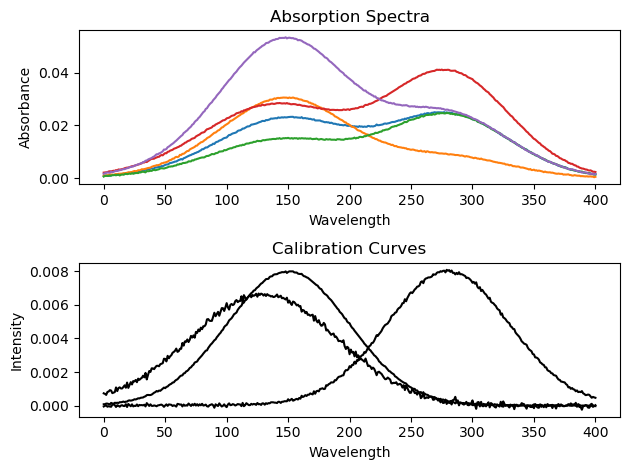

濃度は
[[1 2 3]
 [1 3 1]
 [1 1 3]
 [3 1 5]
 [2 5 3]] 

予測濃度は
[[1.   2.   3.  ]
 [1.01 3.   1.  ]
 [1.   1.   3.  ]
 [3.   1.   5.  ]
 [2.   5.   3.  ]]


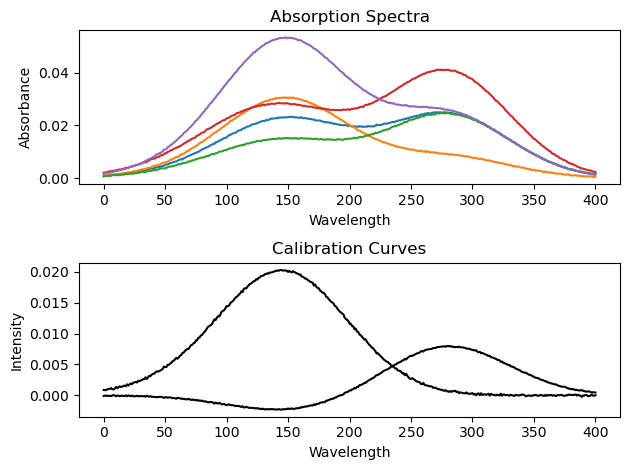

濃度は
[[1 3]
 [1 1]
 [1 3]
 [3 5]
 [2 3]] 

予測濃度は
[[1.46 3.01]
 [1.6  1.02]
 [1.08 3.  ]
 [1.99 4.98]
 [2.94 3.02]]


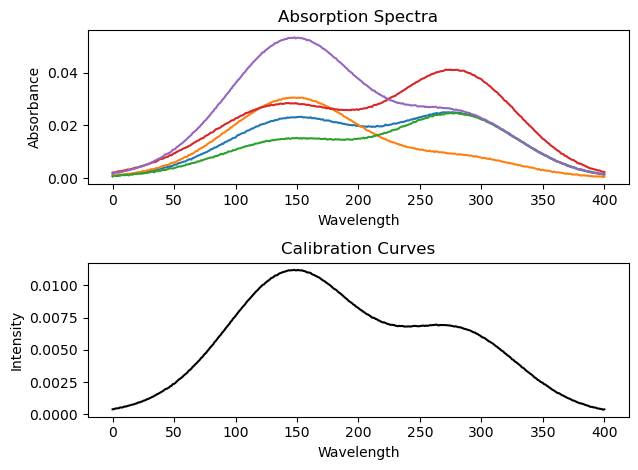

濃度は
[[2]
 [3]
 [1]
 [1]
 [5]] 

予測濃度は
[[2.51]
 [2.33]
 [2.  ]
 [3.58]
 [4.48]]


In [5]:
K,predC=CLSfunction(data,concen[:,:]) # ３成分
K,predC=CLSfunction(data,concen[:,[0,2]]) # ２成分
K,predC=CLSfunction(data,concen[:,[1]]) # １成分

# <span style="color:RoyalBlue; ">6.3 逆最小二乗（ILS）法</span>

## <span style="color: DeepPink; ">6.3.3 ILS法の実装</span>

###### <span style="color: gray ">コード6.4　ILS法による予測濃度の計算とスペクトルを表示する関数</span>

In [7]:
def ILSfunction(A, C):
    """
    Parameters:
    A (numpy.ndarray): 吸収スペクトルデータ
    C (numpy.ndarray): 濃度データ
    Returns:
    numpy.ndarray: 予測濃度（predC）
    """
    # Aの転置（AT）を計算
    AT = A.transpose()
    # ATとAのドット積（ATA）を求める
    ATA = np.dot(AT, A)
    # ATAの逆行列（invATA）を計算
    invATA = np.linalg.inv(ATA)
    # invATAとATとCのドット積（ATC）で検量線（Pils）を計算
    ATC = np.dot(AT, C)
    Pils = np.dot(invATA, ATC)
    # AとPilsのドット積で予測濃度（predC）を計算
    predC = np.dot(A, Pils)
    # 実際の濃度データと予測濃度データをプリント
    print("データ:\n", C)
    print("予測値:\n", predC)
    return predC

###### <span style="color: gray ">コード6.5　関数ILSfunctionの実行</span>

In [9]:
predC=ILSfunction(data[:,[0,130,150,280,400]],concen[:,[0]]) #１成分

データ:
 [[1]
 [1]
 [1]
 [3]
 [2]]
予測値:
 [[1.]
 [1.]
 [1.]
 [3.]
 [2.]]


###### <span style="color: gray ">コード6.6　scikit-learnライブラリのLinearRegressionを用いた回帰</span>

In [10]:
# モデルのインスタンス化
model = LinearRegression()
# モデルの学習（フィッティング）
# Aは吸収スペクトルデータ、Cは濃度データ
model.fit(data[:,[0,130,150,280,400]],concen[:,[0]])
# 予測
predC = model.predict(data[:,[0,130,150,280,400]])
print(predC)

[[1.]
 [1.]
 [1.]
 [3.]
 [2.]]
